In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

In [5]:
sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

In [14]:
kitti_root_dir = './'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)


In [36]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_vx = []  # [vehicle_front_velocity(m/s),] x N
gt_vy = [];  # [vehicle_leftward_velocity(m/s),] x N
gt_ax = [] # [vehicle_front_acceleration(m/s^2),] x N
gt_ay = [] # [vehicle_left_acceleration(m/s^2),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_vx.append(packet.vn)    
    gt_vy.append(packet.ve)    
    gt_ax.append(packet.ax)
    gt_ay.append(packet.ay)


gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_vx = np.array(gt_vx)
gt_vy = np.array(gt_vy)
gt_ax = np.array(gt_ax)
gt_ay = np.array(gt_ay)

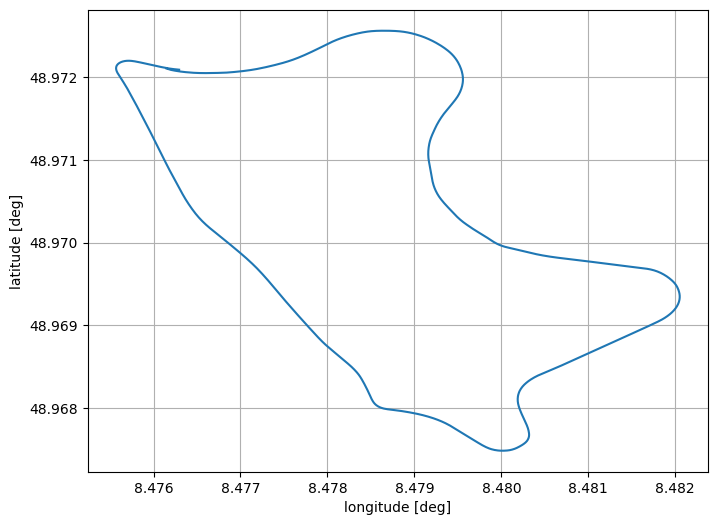

In [37]:
lons, lats, _ = gt_trajectory_lla

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid();


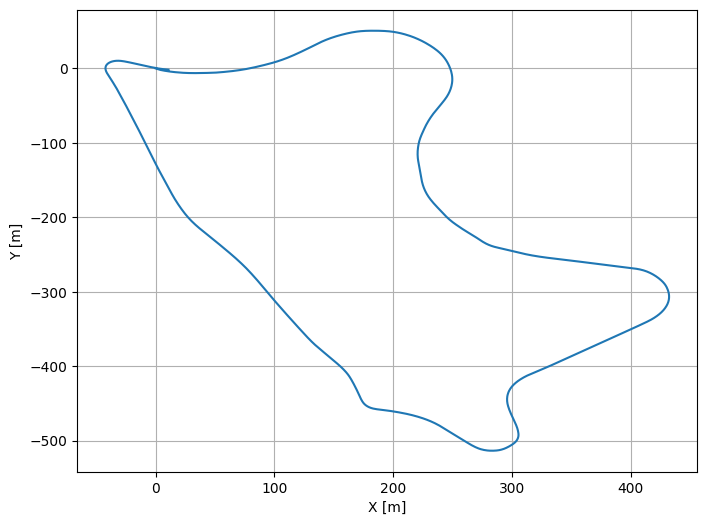

In [38]:
origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin) # convert to x,y,z

xs, ys, _ = gt_trajectory_xyz
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

In [53]:
timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

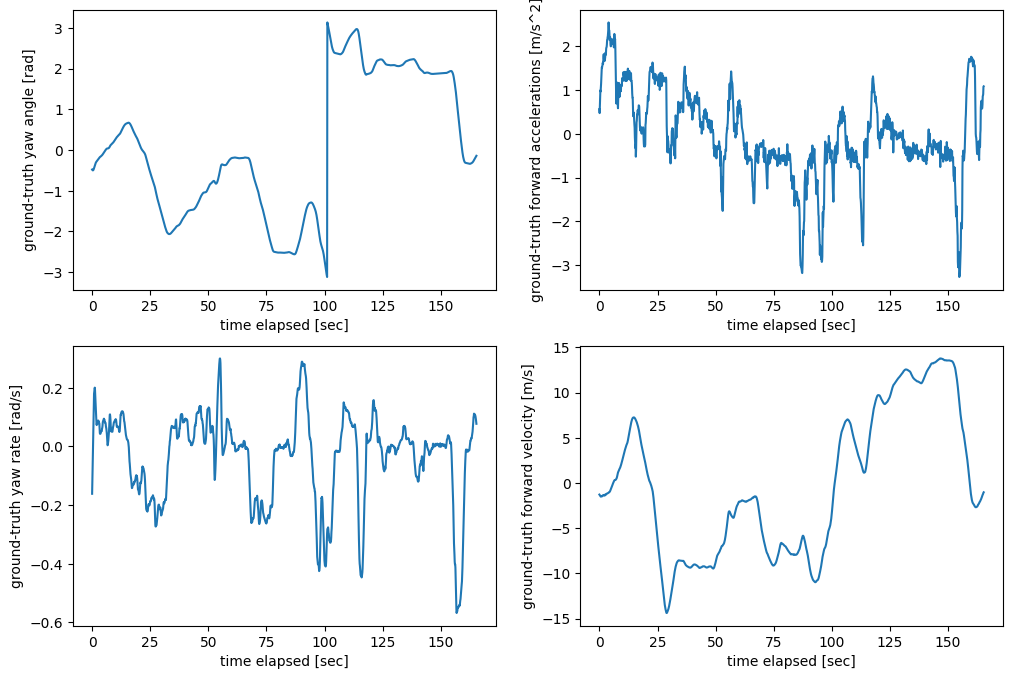

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(ts, gt_yaws)
ax[0, 0].set_xlabel('time elapsed [sec]')
ax[0, 0].set_ylabel('ground-truth yaw angle [rad]')

ax[1, 0].plot(ts, gt_yaw_rates)
ax[1, 0].set_xlabel('time elapsed [sec]')
ax[1, 0].set_ylabel('ground-truth yaw rate [rad/s]')

ax[1, 1].plot(ts, gt_vx)
ax[1, 1].set_xlabel('time elapsed [sec]')
ax[1, 1].set_ylabel('ground-truth forward velocity [m/s]');

ax[0, 1].plot(ts, gt_ax)
ax[0, 1].set_xlabel('time elapsed [sec]')
ax[0, 1].set_ylabel('ground-truth forward accelerations [m/s^2]');

<h2>Add Gaussian noise to each state input</h2>

<h4>Add Gaussian noise to position elements</h4>

In [30]:
xy_obs_noise_std = 5.0  # standard deviation of observation noise of x and y in meters

xy_obs_noise = np.random.normal(0.0, xy_obs_noise_std, (2, N))  # gen gaussian noise
obs_trajectory_xyz = gt_trajectory_xyz.copy()
obs_trajectory_xyz[:2, :] += xy_obs_noise  # add the noise to ground-truth positions

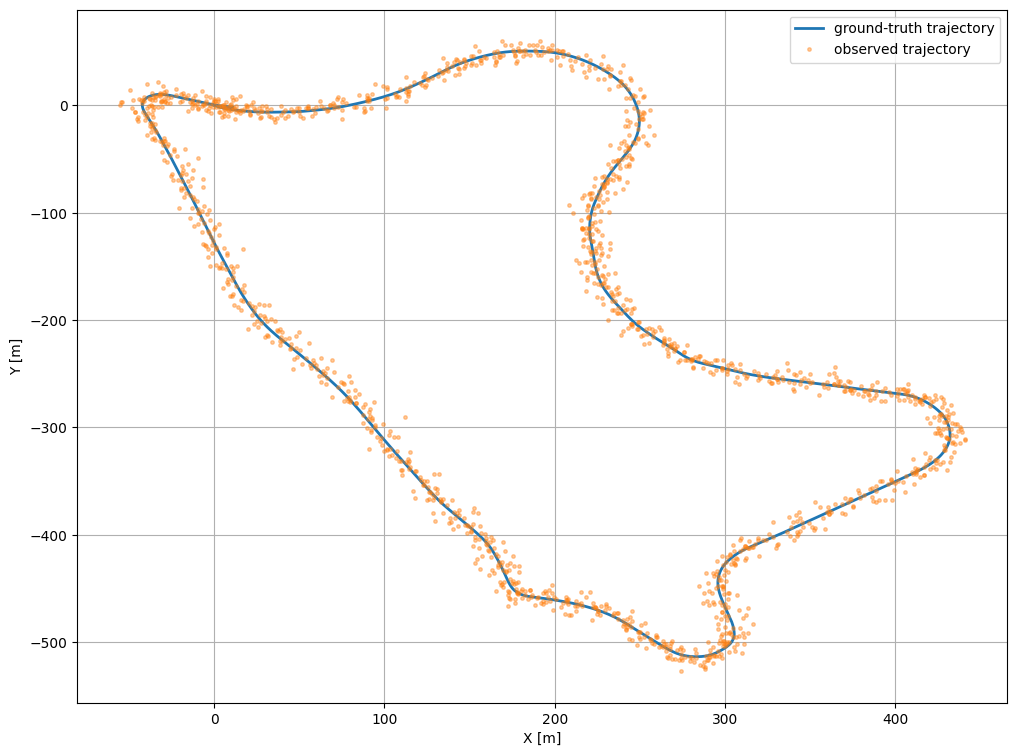

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

x, y, _ = gt_trajectory_xyz
ax.plot(x, y, lw=2, label='ground-truth trajectory')

x, y, _ = obs_trajectory_xyz
ax.plot(x, y, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

<h4>Add Gaussian noise to yaw rate</h4>

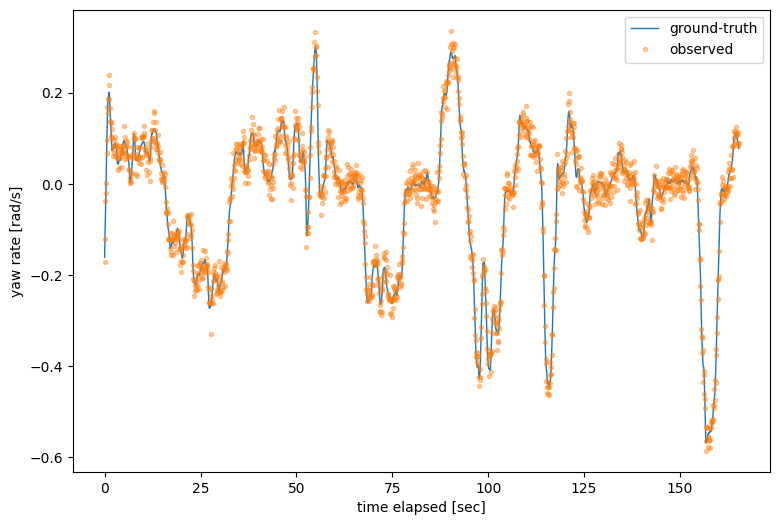

In [33]:
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s

yaw_rate_noise = np.random.normal(0.0, yaw_rate_noise_std, (N,))  # gen gaussian noise
obs_yaw_rates = gt_yaw_rates.copy()
obs_yaw_rates += yaw_rate_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaw_rates, lw=1, label='ground-truth')
ax.plot(ts, obs_yaw_rates, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw rate [rad/s]')
ax.legend();

<h4>Add Gaussian noise to velocity elements</h4>

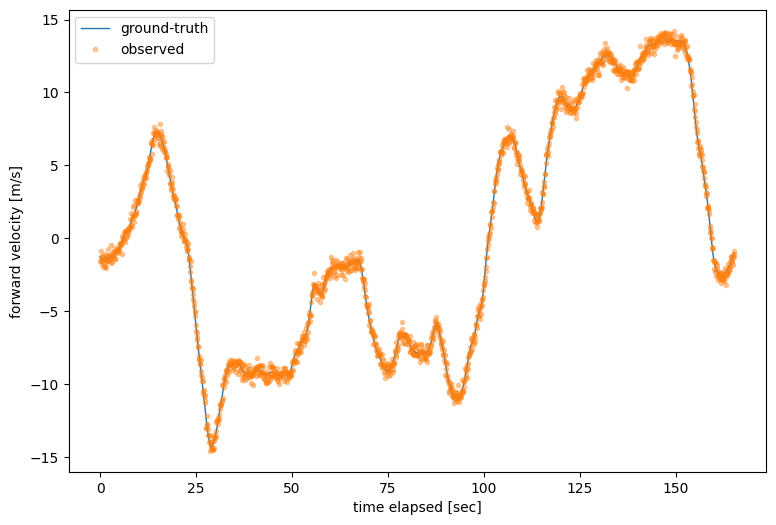

In [50]:
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

forward_velocity_noise = np.random.normal(0.0, forward_velocity_noise_std, (N,))  # gen gaussian noise
obs_forward_velocities = gt_vx.copy()
obs_forward_velocities += forward_velocity_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_vx, lw=1, label='ground-truth')
ax.plot(ts, obs_forward_velocities, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('forward velocity [m/s]')
ax.legend();

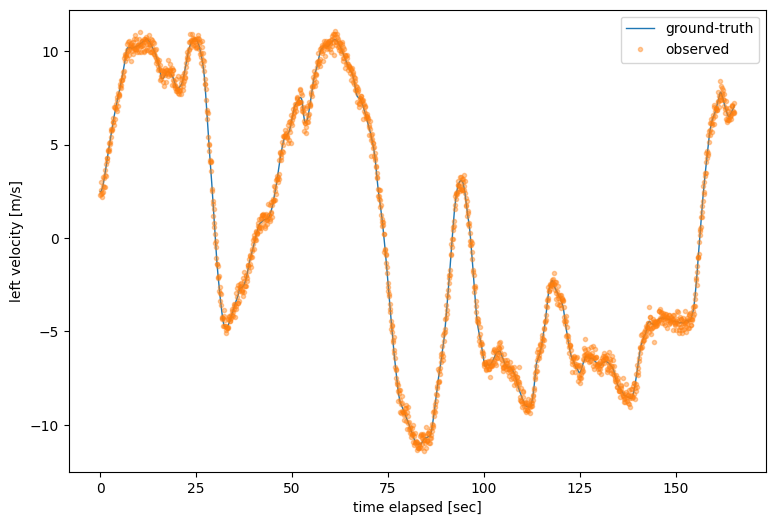

In [51]:
left_velocity_noise_std = 0.3 # standard deviation of left velocity in m/s

left_velocity_noise = np.random.normal(0.0, left_velocity_noise_std, (N,))  # gen gaussian noise
obs_left_velocities = gt_vy.copy()
obs_left_velocities += left_velocity_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_vy, lw=1, label='ground-truth')
ax.plot(ts, obs_left_velocities, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('left velocity [m/s]')
ax.legend();

<h4>Add Gaussian noise to acceleration elements</h4>

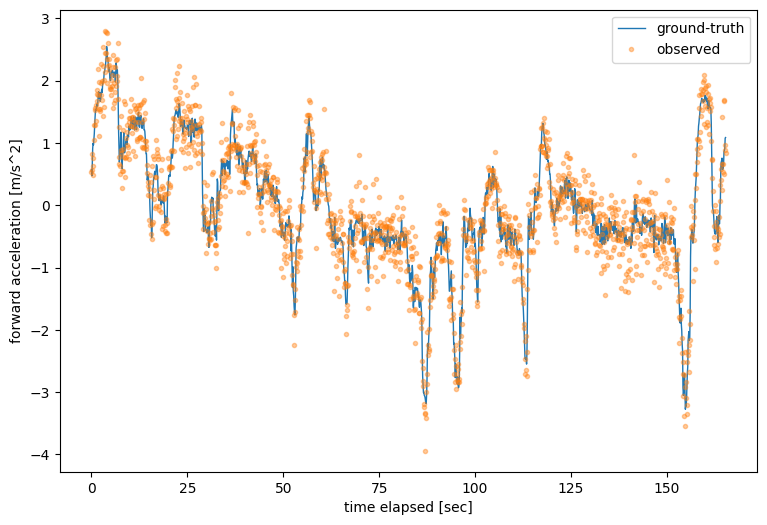

In [100]:
forward_acceleration_noise_std = 0.3 # standard deviation of forward acceleration in m/s^2

forward_acceleration_noise = np.random.normal(0.0, forward_acceleration_noise_std, (N,))  # gen gaussian noise
obs_forward_accelerations = gt_ax.copy()
obs_forward_accelerations += forward_acceleration_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_ax, lw=1, label='ground-truth')
ax.plot(ts, obs_forward_accelerations, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('forward acceleration [m/s^2]')
ax.legend();

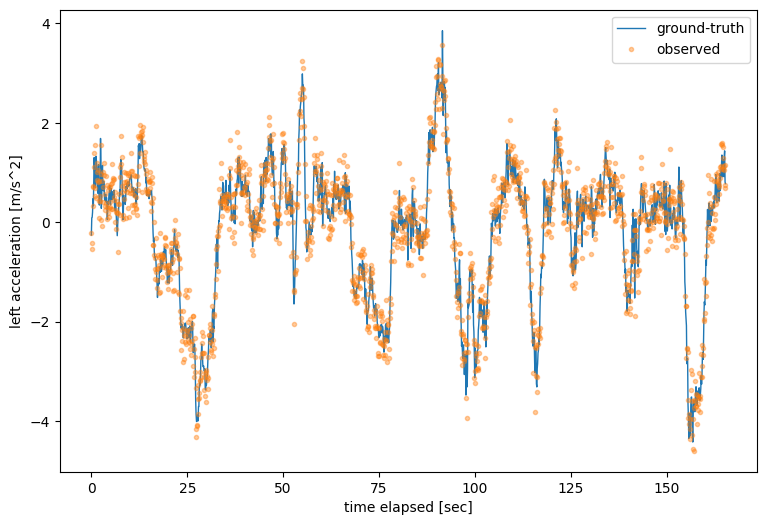

In [101]:
left_acceleration_noise_std = 0.3 # standard deviation of left acceleration in m/s^2

left_acceleration_noise = np.random.normal(0.0, left_acceleration_noise_std, (N,))  # gen gaussian noise
obs_left_accelerations = gt_ay.copy()
obs_left_accelerations += left_acceleration_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_ay, lw=1, label='ground-truth')
ax.plot(ts, obs_left_accelerations, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('left acceleration [m/s^2]')
ax.legend();

<h2>Initialize IMM filter motion models: CV, CA, CT</h2>

<h3>Constant Velocity model definitions</h3>

<h4>Constant Velocity State transition matrix </h4>

In [79]:
CV_model = np.array([
    [1, 0, dt, 0], 
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])    

<h4>Process error covariance Q matrix</h4>


In [72]:
# Compute variances
var_ax = forward_acceleration_noise_std**2  # Variance of acceleration noise in x-direction
var_ay = left_acceleration_noise_std**2  # Variance of acceleration noise in y-direction

# Compute elements of Q
Q11 = (1/3) * (dt**3) * var_ax
Q13 = (1/2) * (dt**2) * var_ax
Q22 = (1/3) * (dt**3) * var_ay
Q24 = (1/2) * (dt**2) * var_ay
Q33 = dt * var_ax
Q44 = dt * var_ay

In [73]:
Q_cv = np.array([
    [Q11, 0,   Q13, 0],
    [0,   Q22, 0,   Q24],
    [Q13, 0,   Q33, 0],
    [0,   Q24, 0,   Q44]
])    

<h4>Define Observation Model H </h4>

In [109]:
H_cv = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

<h4>Measurement Noise Covariance R</h4>

In [113]:
R_cv = np.eye(2) * .1

<h4>Initial State Covariance Matrix P</h4>

In [111]:
P0_cv = np.eye(4) * 1.0

<h4>Define initial state transition matrix X</h4>

In [106]:
# Initial State Estimate (from first measurement)
x0_cv = np.array([
    [x[0]],
    [y[0]], 
    [obs_forward_velocities[0]], 
    [obs_left_velocities[0]]
])

<h3>Constant Acceleration model definitions</h3>

<h4>Constant Acceleration State transition matrix </h4>

In [80]:
CA_model = np.array([
    [1, 0, dt, 0, 0.5 * dt**2, 0], 
    [0, 1, 0, dt, 0, 0.5 * dt**2],
    [0, 0, 1, 0, dt, 0],
    [0, 0, 0, 1, 0, dt],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])    

<h4>Process error covariance Q matrix</h4>

In [81]:
sigma_jx = 0.1 # Tunable
sigma_jy = 0.1 # Tunable

# Compute variances
var_jx = sigma_jx**2  # Variance of jerk noise in x-direction
var_jy = sigma_jy**2  # Variance of jerk noise in y-direction

# Compute elements for Q_x
Qx = np.array([
    [(1/20) * (dt**5) * var_jx, (1/8) * (dt**4) * var_jx, (1/6) * (dt**3) * var_jx],
    [(1/8) * (dt**4) * var_jx,  (1/3) * (dt**3) * var_jx, (1/2) * (dt**2) * var_jx],
    [(1/6) * (dt**3) * var_jx,  (1/2) * (dt**2) * var_jx, dt * var_jx]
])

# Compute elements for Q_y
Qy = np.array([
    [(1/20) * (dt**5) * var_jy, (1/8) * (dt**4) * var_jy, (1/6) * (dt**3) * var_jy],
    [(1/8) * (dt**4) * var_jy,  (1/3) * (dt**3) * var_jy, (1/2) * (dt**2) * var_jy],
    [(1/6) * (dt**3) * var_jy,  (1/2) * (dt**2) * var_jy, dt * var_jy]
])

# Construct the block-diagonal Q matrix
Q_ca = np.block([
    [Qx, np.zeros((3, 3))],
    [np.zeros((3, 3)), Qy]
])

<h4>Define Observation Model H </h4>

In [ ]:
H_ca = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]
])

<h4>Measurement Noise Covariance R</h4>

In [ ]:
R_ca = np.eye(2) * .1

<h4>Initial State Covariance Matrix P</h4>

In [112]:
P0_ca = np.eye(6) * 1.0

<h4>Define initial state transition matrix X</h4>

In [105]:
# Initial State Estimate (from first measurement)
x0_ca = np.array([
    [x[0]],
    [y[0]], 
    [obs_forward_velocities[0]], 
    [obs_left_velocities[0]], 
    [obs_forward_accelerations[0]],
    [obs_left_accelerations[0]]
])

<h2>Define IMM filter parameters</h2> <h4>The IMM algorithm consists of four steps.</h4> <br> <li>Step 1: Interaction</li> <li>Step 2: Filtering</li> <li>Step 3: Updating the probability of the model</li> <li>Step 4: Combination</li>

<h4>Define Sampling Time</h4>

In [82]:
# Compute sampling time between consecutive timestamps and then take the mean
dt = np.diff(ts)  
dt = np.mean(dt)

<h4>Define the number of k steps</h4>

In [83]:
N = len(ts)  # number of data points

<h4>Define the number of motion models</h4>

In [84]:
M = 2;

<h4>Define the transition probability matrix</h4>

In [88]:
# Setting each model likely initially
T =  np.array([
    [0.95, 0.95],
    [0.95, 0.95]
])

<h4>Define initial mixed probability</h4>

In [89]:
# Assume each model has the same probability
mu = np.array([
    [0.5, 0.5]
])

<h2>Step 1: Interaction</h2> <h4>At the interaction step, estimation of each filter model is mixed mathematically to produce initial conditions  for input of each filter model.</h4>

In [ ]:
np.zeros(M)